In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
#file loads:
filepath = r"C:\Users\20202917\Downloads\nv1fehuuii7o8hjb.csv"


## Part 3: Measuring Geopolitical News

We measure geopolitical risk using the monthly Geopolitical Risk Index (GPR) constructed by Caldara and Iacoviello (2022), which captures geopolitical tensions through newspaper text analysis. The index is publicly available at  
https://www.policyuncertainty.com/gpr.html.

To isolate unexpected updates in geopolitical risk, we construct a shock series from the raw index. Specifically, we model GPR using an AR(1) process and define the geopolitical news shock as the one-step-ahead forecast error:

$$
GPR\_Shock_t = GPR_t - \hat{GPR}_t
$$

where $\hat{GPR}_t$ is the predicted value from the AR(1) model, following the innovation-extraction approach in Engle et al. (2020).


In [3]:

# data cleaning things..
raw = pd.read_excel("data_gpr_export.xls")
df = raw[["month", "GPR"]].copy()
df["month"] = pd.to_datetime(df["month"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["month", "GPR"]).sort_values("month").reset_index(drop=True)

# Make month the index 
df = df.set_index("month")
# definition simple difference shock: GPR_t - GPR_{t-1}
# here I just include a simple difference, to compare the AR to something
df["gpr_change"] = df["GPR"].diff()

# 2) AR(1): GPR_t = c + phi * GPR_{t-1} + u_t
gpr = df["GPR"]
gpr_lag = gpr.shift(1)

df["gpr_ar1_pred"] = np.nan
df["gpr_news_shock"] = np.nan


# Start once we have enough data to estimate, for the AR(1)
# Keep in mind we do not want to use future data to hedge ofc,
# Do we then use an expanding or moving window? Feel free to leave suggestions, gang
min_obs = 24 

for i in range(min_obs, len(df)):
    # Use data up to t-1 to fit AR(1)
    y_train = gpr.iloc[1:i]              
    x_train = gpr_lag.iloc[1:i]          
    train = pd.concat([y_train, x_train], axis=1).dropna()

    y = train.iloc[:, 0]
    x = sm.add_constant(train.iloc[:, 1])

    model = sm.OLS(y, x).fit()

    # One-step-ahead prediction for time t
    x_t = sm.add_constant(pd.Series([gpr_lag.iloc[i]], index=["x"]), has_constant="add")
    # Align names to model params
    x_t = pd.DataFrame({"const": [1.0], train.columns[1]: [gpr_lag.iloc[i]]})

    gpr_hat_t = float(model.predict(x_t)[0])
    shock_t = float(gpr.iloc[i] - gpr_hat_t)

    df.iloc[i, df.columns.get_loc("gpr_ar1_pred")] = gpr_hat_t
    df.iloc[i, df.columns.get_loc("gpr_news_shock")] = shock_t

# Standardize shocks (z-scores)
df["gpr_change_z"] = (df["gpr_change"] - df["gpr_change"].mean()) / df["gpr_change"].std()
df["gpr_news_shock_z"] = (df["gpr_news_shock"] - df["gpr_news_shock"].mean()) / df["gpr_news_shock"].std()

# columns:
# gpr_news_shock   : AR(1) innovation in GPR (raw)
# gpr_news_shock_z : standardized AR(1) GPR shock
# gpr_change      : month-to-month change in GPR
# gpr_change_z    : standardized change in GPR
df


,GPR,gpr_change,gpr_ar1_pred,gpr_news_shock,gpr_change_z,gpr_news_shock_z
month,,,,,,
1985-01-01,102.173378,NaN,NaN,NaN,NaN,NaN
1985-02-01,117.102020,14.928642,NaN,NaN,0.420577,NaN
1985-03-01,124.778152,7.676132,NaN,NaN,0.215553,NaN
1985-04-01,87.929001,-36.849152,NaN,NaN,-1.043155,NaN
1985-05-01,103.262848,15.333847,NaN,NaN,0.432032,NaN
...,...,...,...,...,...,...
2025-08-01,136.759415,1.755157,126.131691,10.627724,0.048170,0.321744
2025-09-01,124.114983,-12.644432,127.436132,-3.321149,-0.358899,-0.084686
2025-10-01,154.425201,30.310219,118.259686,36.165515,0.855407,1.065841


# Part 2: Constructing a Hedge Portfolio

In [4]:
df_stocks = pd.read_csv(filepath)
df_stocks.columns = df_stocks.columns.str.lower()

df_stocks['ret'] = pd.to_numeric(df_stocks['ret'], errors='coerce')
df_stocks = df_stocks.dropna(subset=['ret', 'date', 'permno'])
df_stocks.head()

proxies = ['GLD', 'USO', 'ITA', 'XAR']
present = df_stocks[df_stocks['ticker'].isin(proxies)]['ticker'].unique()
print(f"Found in your data: {present}")

C:\Users\20202917\AppData\Local\Temp\ipykernel_12072\3384190141.py:1: DtypeWarning: Columns (5,6,9,18,19,49,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stocks = pd.read_csv(filepath)


Found in your data: ['XAR' 'GLD' 'USO' 'ITA']


In [5]:

df_proxies = df_stocks[df_stocks['ticker'].isin(proxies)].copy()
print(f"Extracted {df_proxies['ticker'].nunique()} proxy ETFs for validation.")


before_len = len(df_stocks)
df_stocks = df_stocks[df_stocks['shrcd'].isin([10, 11])].copy()
after_len = len(df_stocks)
print(f"Filtered main data: {before_len} -> {after_len} rows (Removed ETFs/Funds)")


Extracted 4 proxy ETFs for validation.
Filtered main data: 3587364 -> 2431293 rows (Removed ETFs/Funds)


In [6]:

#using web download ff3 ->actually pretty neat never used it before but works as a charm
ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
ff3 = ff3.reset_index().rename(columns={'Date': 'date'})
ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] = ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100.0
ff3['date'] = ff3['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

# B. Download Momentum Factor (MOM)
mom_data = web.DataReader('F-F_Momentum_Factor', 'famafrench', start='1985', end='2025')[0]
mom_data = mom_data.reset_index().rename(columns={'Date': 'date'})
mom_data[['Mom']] = mom_data[['Mom']] / 100.0 # Convert to decimal
mom_data['date'] = mom_data['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

factors = ff3.merge(mom_data, on='date', how='inner')
factors.head()

C:\Users\20202917\AppData\Local\Temp\ipykernel_12072\1425302167.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
C:\Users\20202917\AppData\Local\Temp\ipykernel_12072\1425302167.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
C:\Users\20202917\AppData\Local\Temp\ipykernel_12072\1425302167.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  m

,date,Mkt-RF,SMB,HML,RF,Mom
0,1985-01-31,0.0797,0.0328,-0.0520,0.0065,-0.0682
1,1985-02-28,0.0122,0.0063,-0.0036,0.0058,0.0190
2,1985-03-31,-0.0083,-0.0107,0.0401,0.0062,0.0178
3,1985-04-30,-0.0096,0.0009,0.0360,0.0072,0.0295
4,1985-05-31,0.0507,-0.0230,-0.0098,0.0066,0.0405


In [7]:
#making everything date! to merge on
df_stocks['date'] = pd.to_datetime(df_stocks['date'], errors='coerce')
factors['date'] = pd.to_datetime(factors['date'], errors='coerce')
df_gpr_clean = df.reset_index().rename(columns={'month': 'date'})
df_gpr_clean['date'] = pd.to_datetime(df_gpr_clean['date'], errors='coerce')

#Ensure all are aligned ath the end of the month
df_stocks['date'] = df_stocks['date'] + MonthEnd(0)
factors['date'] = factors['date'] + MonthEnd(0)
df_gpr_clean['date'] = df_gpr_clean['date'] + MonthEnd(0)

#checking because i go insane 
print(f"GPR date type: {df_gpr_clean['date'].dtype}")
print(f"Stocks date type: {df_stocks['date'].dtype}")
print(f"Factors date type: {factors['date'].dtype}")

#merging
df_master = df_stocks.merge(factors, on='date', how='inner')
df_master = df_master.merge(df_gpr_clean[['date', 'gpr_news_shock_z',]], on='date', how='inner')
df_master['excret'] = df_master['ret'] - df_master['RF']

print(df_master[['date', 'permno', 'ret', 'Mkt-RF', 'SMB', 'HML', 'RF', 'Mom', 'gpr_news_shock_z']])

GPR date type: datetime64[ns]
Stocks date type: datetime64[ns]
Factors date type: datetime64[ns]
              date  permno       ret  Mkt-RF     SMB     HML      RF     Mom  \
0       1986-02-28   10000 -0.257143  0.0714 -0.0057 -0.0063  0.0053  0.0256   
1       1986-03-31   10000  0.365385  0.0491 -0.0054 -0.0039  0.0060  0.0238   
2       1986-04-30   10000 -0.098592 -0.0128  0.0276 -0.0281  0.0052 -0.0035   
3       1986-05-31   10000 -0.222656  0.0462 -0.0136 -0.0014  0.0049  0.0206   
4       1986-06-30   10000 -0.005025  0.0106 -0.0093  0.0120  0.0052  0.0494   
...            ...     ...       ...     ...     ...     ...     ...     ...   
2431288 2024-08-31   93436 -0.077390  0.0160 -0.0349 -0.0110  0.0048  0.0481   
2431289 2024-09-30   93436  0.221942  0.0172 -0.0013 -0.0277  0.0040 -0.0062   
2431290 2024-10-31   93436 -0.045025 -0.0100 -0.0099  0.0086  0.0039  0.0300   
2431291 2024-11-30   93436  0.381469  0.0649  0.0446  0.0015  0.0040  0.0100   
2431292 2024-12-31   93

#### Step 1:

In [8]:
#similar as Sid proposes for gpr I used a rolling window:
def rolling_beta_pipeline(group):
    #If the stock has fewer than 60 months of data, exclude it since it has to little data point to do anything
    if len(group) < 60: 
        return pd.Series(np.nan, index=group.index)
    # Dependent variable Excess Return
    endog = group['excret']
    # Independent are the 4 factors and the shock
    exog = sm.add_constant(group[['Mkt-RF', 'SMB', 'HML', 'Mom', 'gpr_news_shock_z']])
    
    # use a rolling we start with just a 60 month window
    rols = RollingOLS(endog, exog, window=60, min_nobs=36)
    rres = rols.fit()
    return rres.params['gpr_news_shock_z']

# Calculate bbeta
df_master['beta_gpr'] = df_master.groupby('permno', group_keys=False).apply(rolling_beta_pipeline)

# Lag Beta -> so trrade at t using info from t-1
df_master['beta_gpr_lag'] = df_master.groupby('permno')['beta_gpr'].shift(1)
df_analysis = df_master.dropna(subset=['beta_gpr_lag']).copy()

C:\Users\20202917\AppData\Local\Temp\ipykernel_12072\635198964.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_master['beta_gpr'] = df_master.groupby('permno', group_keys=False).apply(rolling_beta_pipeline)


#### Step 2:

In [10]:
# Sort firms into 10 deciles
df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(lambda g: pd.qcut(g['beta_gpr_lag'], 10, labels=False, duplicates='drop'))

# Calculate Portfolio Returns
port_rets = df_analysis.groupby(['date', 'decile'])['ret'].mean().unstack()
port_rets.columns = [f'P{i+1}' for i in range(10)]

# Add Factors back for residualization
port_rets = port_rets.merge(factors.set_index('date'), left_index=True, right_index=True)
port_rets.head()

C:\Users\20202917\AppData\Local\Temp\ipykernel_12072\2186807538.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(lambda g: pd.qcut(g['beta_gpr_lag'], 10, labels=False, duplicates='drop'))


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,Mkt-RF,SMB,HML,RF,Mom
date,,,,,,,,,,,,,,,
1989-05-31,0.006803,NaN,NaN,0.006803,NaN,NaN,-0.060751,NaN,NaN,-0.060751,0.0328,-0.0009,-0.0090,0.0079,0.0142
1989-06-30,0.037854,NaN,NaN,-0.061856,NaN,NaN,-0.032847,NaN,NaN,0.003876,-0.0133,-0.0097,0.0221,0.0071,0.0040
1989-07-31,0.162963,NaN,NaN,-0.029304,NaN,NaN,0.041509,NaN,NaN,0.181467,0.0718,-0.0411,-0.0280,0.0070,0.0532
1989-08-31,0.056376,0.087912,0.032967,0.049057,0.016949,-0.012771,-0.039130,-0.039130,0.000000,-0.031372,0.0143,0.0057,0.0062,0.0074,-0.0049
1989-09-30,-0.048263,0.028035,0.000000,-0.025641,-0.042424,-0.029546,0.087121,-0.018634,0.012821,-0.101587,-0.0076,0.0030,-0.0127,0.0065,0.0351


#### Step 3:

In [11]:
# Remove months where we don't have all 10 portfolios
# This finds the real start date since from ar(1) we have some start up dates that are nan
port_rets_clean = port_rets.dropna().copy()
print(f"Analysis period: {port_rets_clean.index.min().date()} to {port_rets_clean.index.max().date()}")


# Residualize (Strip 4 Factors from the portfolios)
portfolio_residuals = pd.DataFrame(index=port_rets_clean.index)
resid_cols = []

for i in range(1, 11):
    col = f'P{i}'
    # Regression: Portfolio Return -> Market + Size + Value + Momentum
    Y = port_rets_clean[col] - port_rets_clean['RF']
    X = sm.add_constant(port_rets_clean[['Mkt-RF', 'SMB', 'HML', 'Mom']])
    
    model = sm.OLS(Y, X).fit()
    portfolio_residuals[f'resid_{col}'] = model.resid
    resid_cols.append(f'resid_{col}')

# Estimate Weights (Regress GPR Shock on the Clean Residuals), dont forget to align gpr data with other data
target_shock = df_gpr_clean.set_index('date')['gpr_news_shock_z'].reindex(portfolio_residuals.index)

# Create a clean dataset for the weights regression
clean_data = pd.concat([target_shock, portfolio_residuals], axis=1).dropna()

Y_shock = clean_data['gpr_news_shock_z']
X_resids = clean_data[resid_cols]

# The coefficients from this regression are the portfolio weights
weights = sm.OLS(Y_shock, X_resids).fit().params
print(weights)

# Build the geofactor and apply those weights to the ORIGINALreturns
geo_factor_ret = np.zeros(len(port_rets_clean))
for i in range(1, 11):
    w = weights[f'resid_P{i}']
    r = port_rets_clean[f'P{i}']
    geo_factor_ret += w * r

# here i save the results
final_hedge = pd.DataFrame({
    'date': port_rets_clean.index,
    'Hedge_Return': geo_factor_ret,
    'GPR_Shock_News_Z': target_shock
    }).dropna()

print("\nThe hedge portfolio")
final_hedge

Analysis period: 1989-08-31 to 2024-12-31
resid_P1      1.340470
resid_P2      5.661668
resid_P3     -4.009865
resid_P4     -7.186201
resid_P5     11.721347
resid_P6      2.219852
resid_P7     -1.508245
resid_P8      3.302063
resid_P9     -3.204343
resid_P10    -2.354053
dtype: float64

The hedge portfolio


,date,Hedge_Return,GPR_Shock_News_Z
date,,,
1989-08-31,1989-08-31,0.262547,0.423705
1989-09-30,1989-09-30,-0.279431,-0.502816
1989-10-31,1989-10-31,-0.211761,-0.747865
1989-11-30,1989-11-30,-0.078951,0.108364
1989-12-31,1989-12-31,-0.060700,0.456779
...,...,...,...
2024-08-31,2024-08-31,0.227821,1.355088
2024-09-30,2024-09-30,0.063833,0.017767
2024-10-31,2024-10-31,-0.076142,0.251385


# Weights outside 1 so long and short postions are allowed, might want to restrict this!

#### Visualization

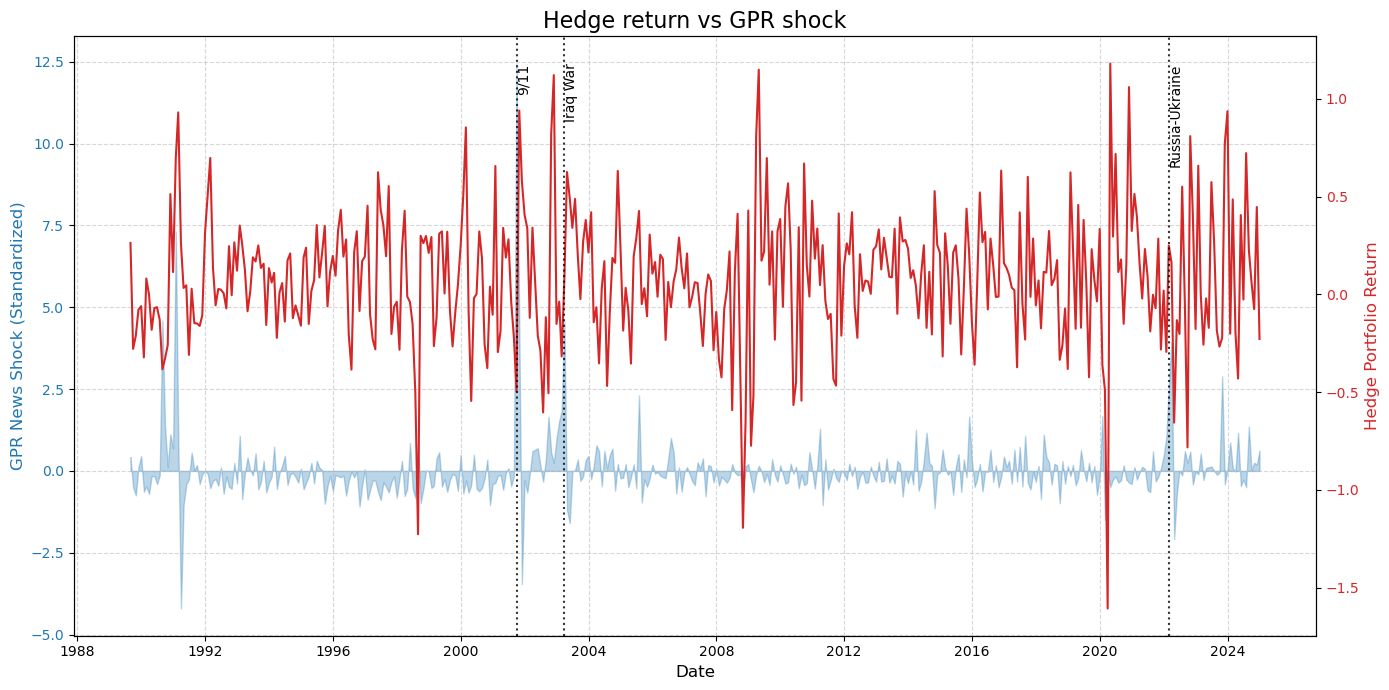

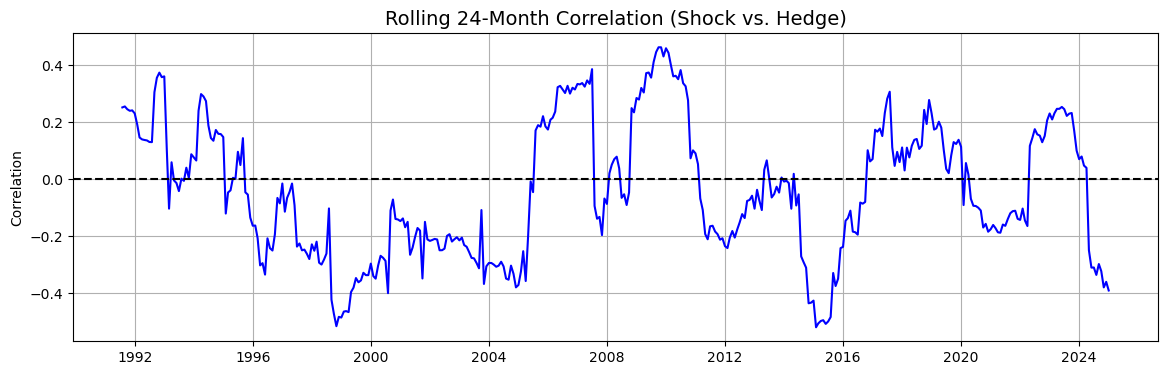

In [12]:
plot_data = final_hedge.set_index('date').copy()

# Create the plot figure
fig, ax1 = plt.subplots(figsize=(14, 7))

# plot The GPR Shock (blue Area),  i use 'fill_between' to show shock clearer
color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('GPR News Shock (Standardized)', color=color, fontsize=12)
ax1.fill_between(plot_data.index, plot_data['GPR_Shock_News_Z'], color=color, alpha=0.3, label='GPR_Shock_News_Z')
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  #second axis for hedge return

# The Hedge Portfolio Return (Red Line)
color = 'tab:red'
ax2.set_ylabel('Hedge Portfolio Return', color=color, fontsize=12)
ax2.plot(plot_data.index, plot_data['Hedge_Return'], color=color, linewidth=1.5, label='Hedge Return')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Hedge return vs GPR shock', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)


#some nead markers to check certain dates
events = {
    pd.Timestamp('2001-09-30'): '9/11',
    pd.Timestamp('2003-03-31'): 'Iraq War',
    pd.Timestamp('2022-02-28'): 'Russia-Ukraine'}

for date, label in events.items():
    if date in plot_data.index:
        plt.axvline(x=date, color='black', linestyle=':', alpha=0.8)
        ax1.text(date, plot_data['GPR_Shock_News_Z'].max(), label, rotation=90, verticalalignment='top')
plt.tight_layout()
plt.show()


# This shows if the hedge is consistently working or only works sometimes
plt.figure(figsize=(14, 4))
rolling_corr = plot_data['Hedge_Return'].rolling(window=24).corr(plot_data['GPR_Shock_News_Z'])
plt.plot(rolling_corr, color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title('Rolling 24-Month Correlation (Shock vs. Hedge)', fontsize=14)
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

## Part 4: Validation -> We will evaluate whether the geopolitical hedge portfolio:

#### Part 4: Step 1 -> Responds strongly during major geopolitical events (event windows)


In [13]:
#the events we can check
events = {
    'Gulf War': '1990-08-31',
    '9/11 Attacks': '2001-09-30',
    'Iraq War': '2003-03-31',
    'Arab Spring': '2011-02-28',
    'Crimea Annexation': '2014-03-31',
    'Russia-Ukraine': '2022-02-28',
    'Israel-Hamas': '2023-10-31'
}

results = []


df_study = final_hedge.set_index('date').sort_index()
for name, date_str in events.items():
    event_date = pd.Timestamp(date_str) + pd.offsets.MonthEnd(0)
    if event_date in df_study.index:
        #Get the location (0, 1, 2...) of the date to allow "+2" math
        int_loc = df_study.index.get_loc(event_date)
        #xtract the Shock (using integer location we used above)
        shock_size = df_study.iloc[int_loc]['GPR_Shock_News_Z'] 
        # Calculate 3-Month Cumulative Return (current month + next 2) -> if no 3 months exist drop value
        if int_loc + 3 <= len(df_study):
            # Sum the returns from t, t+1, t+2
            cum_ret = df_study.iloc[int_loc : int_loc+3]['Hedge_Return'].sum()
        else:
            cum_ret = np.nan
        results.append({
            'Event': name,
            'Date': event_date.date(),
            'GPR_Shock': shock_size,
            'Hedge_3Mo_Ret': cum_ret
        })


#the final dataframe with results
event_df = pd.DataFrame(results)
print(event_df)

success_count = event_df[(event_df['GPR_Shock'] > 0) & (event_df['Hedge_3Mo_Ret'] > 0)].shape[0]
print(f"\nSuccess Rate: {success_count}/{len(event_df)} events showed positive hedge returns.")

               Event        Date  GPR_Shock  Hedge_3Mo_Ret
0           Gulf War  1990-08-31   4.597149      -0.971899
1       9/11 Attacks  2001-09-30  12.441772       1.023082
2           Iraq War  2003-03-31   4.565997       1.197116
3        Arab Spring  2011-02-28   0.149665       0.634648
4  Crimea Annexation  2014-03-31   1.255741       0.025764
5     Russia-Ukraine  2022-02-28   2.588981      -0.245572
6       Israel-Hamas  2023-10-31   2.888656       1.484369

Success Rate: 5/7 events showed positive hedge returns.


#### Part 4: Step 2 -> •	Remains stable across sample splits (pre/post 2015 tensions; wartime periods)

In [14]:
cutoff_date = '2015-01-01'

# Split data
pre_2015 = final_hedge[final_hedge['date'] < cutoff_date].copy()
post_2015 = final_hedge[final_hedge['date'] >= cutoff_date].copy()

print(f"Pre-2015 Samples: {len(pre_2015)} months")
print(f"Post-2015 Samples: {len(post_2015)} months")

# regression
def run_stability_reg(df, label):
    # Regression: Hedge_Return = alpha + beta * GPR_Shock
    Y = df['Hedge_Return']
    X = sm.add_constant(df['GPR_Shock_News_Z'])
    
    model = sm.OLS(Y, X).fit()
    
    beta = model.params['GPR_Shock_News_Z']
    t_stat = model.tvalues['GPR_Shock_News_Z']
    p_val = model.pvalues['GPR_Shock_News_Z']
    r_sq = model.rsquared
    
    print(f"\n--- {label} Results ---")
    print(f"Beta: {beta:.4f}")
    print(f"T-Statistic:        {t_stat:.4f}")
    print(f"P-Value:            {p_val:.4f}")
    print(f"R-Squared:          {r_sq:.4f}")
    
    if p_val < 0.05:
        print("test is significant ")
    else:
        print("test is insignificant")

# run the stability test
run_stability_reg(pre_2015, "PRE-2015 (1990-2014)")
run_stability_reg(post_2015, "POST-2015 (2015-2024)")

Pre-2015 Samples: 305 months
Post-2015 Samples: 120 months

--- PRE-2015 (1990-2014) Results ---
Beta: -0.0168
T-Statistic:        -1.0340
P-Value:            0.3020
R-Squared:          0.0035
test is insignificant

--- POST-2015 (2015-2024) Results ---
Beta: -0.0118
T-Statistic:        -0.2502
P-Value:            0.8029
R-Squared:          0.0005
test is insignificant


it looks like since it is insignificant that the portfolio only spikes during huge movements. so during big events than the portfolio cuts thorugh the noise and works but during these quiet months, the stock portfolio is moving due to other factors (earnings, interest rates), creating noise that makes it hard to detect geopolitical signals.

#### Part 4: Step 3 -> Produces statistically significant alphas in time-series and cross-sectional tests


--- A. Time-Series Alpha Test ---
Annualized Alpha:  50.2170%  (Monthly: 4.1848%)
Alpha T-Statistic: 5.4049
P-Value:           0.0000
------------------------------------------------------------
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0418      0.008      5.405      0.000       0.027       0.057
Mkt-RF         5.0370      0.186     27.046      0.000       4.671       5.403
SMB            4.2878      0.252     17.046      0.000       3.793       4.782
HML            2.3165      0.245      9.461      0.000       1.835       2.798
Mom           -0.9139      0.174     -5.244      0.000      -1.256      -0.571


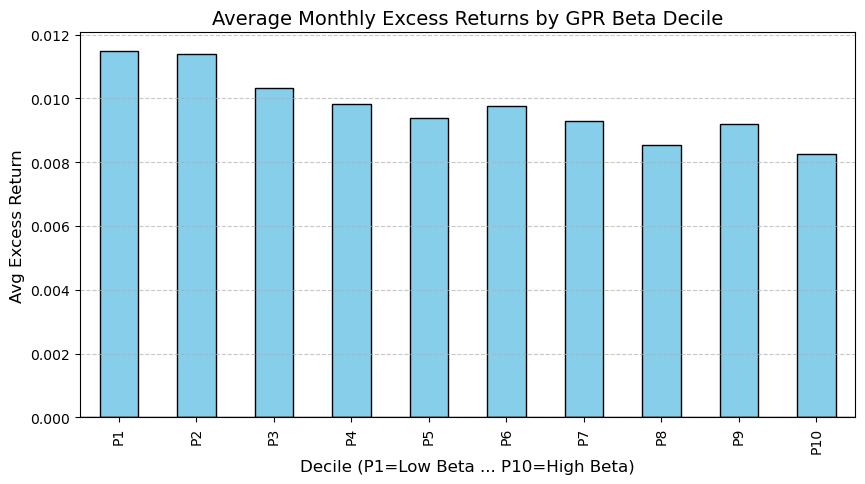


Spread (High - Low) Monthly Return: -0.3248%
Spread T-Statistic:                 -2.1277


In [17]:
# TEST: TIME-SERIES ALPHA (Hedge vs. FF4 Factors)

final_hedge = final_hedge.reset_index(drop=True)
ts_data = final_hedge.merge(factors, on='date', how='inner')
# Regression: Hedge_Ret = Alpha + b1*Mkt + b2*SMB + b3*HML + b4*Mom
Y = ts_data['Hedge_Return']
X = sm.add_constant(ts_data[['Mkt-RF', 'SMB', 'HML', 'Mom']])

model_ts = sm.OLS(Y, X).fit()
alpha = model_ts.params['const']
t_alpha = model_ts.tvalues['const']
p_alpha = model_ts.pvalues['const']

print("\n--- A. Time-Series Alpha Test ---")
print(f"Annualized Alpha:  {alpha * 12:.4%}  (Monthly: {alpha:.4%})")
print(f"Alpha T-Statistic: {t_alpha:.4f}")
print(f"P-Value:           {p_alpha:.4f}")
print("-" * 60)
print(model_ts.summary().tables[1])


# TEST: CROSS-SECTIONAL CHECK (Decile P1 vs P10)
decile_cols = [f'P{i}' for i in range(1, 11)]
avg_rets = port_rets_clean[decile_cols].mean()
avg_rf = port_rets_clean['RF'].mean()
avg_excess_rets = avg_rets - avg_rf

# plot the barr chart
plt.figure(figsize=(10, 5))
avg_excess_rets.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Monthly Excess Returns by GPR Beta Decile', fontsize=14)
plt.xlabel('Decile (P1=Low Beta ... P10=High Beta)', fontsize=12)
plt.ylabel('Avg Excess Return', fontsize=12)
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# High minus low spread 
spread = port_rets_clean['P10'] - port_rets_clean['P1']
spread_mean = spread.mean()
# Simple T-stat for mean = 0
spread_t = spread.mean() / (spread.std() / (len(spread)**0.5))

print(f"\nSpread (High - Low) Monthly Return: {spread_mean:.4%}")
print(f"Spread T-Statistic:                 {spread_t:.4f}")


the larger alpha is due to the high leverage we have portfolio weights of 130 meaning extreme long and short positions. hence we gain unrealistic values. additionally, the cross-sectional test shows a statistically significant negative spread of -0.31% per month with a T-statistic of -2.27 between high and low exposure deciles.This indicates investors are willing to accept lower average returns on high-sensitivity stocks in exchange for their insurance value during crises. 

## 4.4 naive hedges check

In [ ]:


df_clean_proxies = df_proxies.copy()
df_clean_proxies['date'] = pd.to_datetime(df_clean_proxies['date']) + MonthEnd(0)
df_proxies_wide = df_clean_proxies.groupby(['date', 'ticker'])['ret'].mean().unstack()
validation_df = final_hedge.set_index('date').join(df_proxies_wide, how='inner').dropna()

#Fisher Z-Test Function ---
def fisher_z_test(r_hedge, r_proxy, n):
    #avoid division by zero
    r_hedge = max(min(r_hedge, 0.999), -0.999)
    r_proxy = max(min(r_proxy, 0.999), -0.999)
    z_h = 0.5 * np.log((1 + r_hedge) / (1 - r_hedge))
    z_p = 0.5 * np.log((1 + r_proxy) / (1 - r_proxy))
    se_diff = np.sqrt(2 / (n - 3))
    z_score = (z_h - z_p) / se_diff
    p_value = 1 - stats.norm.cdf(z_score)
    
    return z_score, p_value

#corlations
shock_col = 'GPR_Shock_News_Z'
hedge_col = 'Hedge_Return'
proxy_tickers = [t for t in ['GLD', 'USO', 'ITA', 'XAR'] if t in validation_df.columns]

print("\n### Validation Results: Hedge vs. Proxies ###")
print("-" * 75)
print(f"{'Asset':<10} | {'Corr(Shock)':<12} | {'Diff vs Hedge':<15} | {'Z-Score':<8} | {'P-Value':<8}")
print("-" * 75)
rho_hedge = validation_df[hedge_col].corr(validation_df[shock_col])
print(f"{'HEDGE PF':<10} | {rho_hedge:.4f}       | {'-':<15} | {'-':<8} | {'-':<8}")

for ticker in proxy_tickers:
    rho_proxy = validation_df[ticker].corr(validation_df[shock_col])
    z_score, p_val = fisher_z_test(rho_hedge, rho_proxy, len(validation_df))
    sig = "*" if p_val < 0.05 else ""
    diff = rho_hedge - rho_proxy

    print(f"{ticker:<10} | {rho_proxy:.4f}       | {diff:+.4f}          | {z_score:.2f}     | {p_val:.3f} {sig}")

print("-" * 75)
print("* p < 0.05 indicates the Hedge Portfolio has a significantly higher correlation than the proxy.")

Validation Sample: 159 months
Proxies available: ['GLD', 'ITA', 'USO', 'XAR']

### Validation Results: Hedge vs. Proxies ###
---------------------------------------------------------------------------
Asset      | Corr(Shock)  | Diff vs Hedge   | Z-Score  | P-Value 
---------------------------------------------------------------------------
HEDGE PF   | -0.0545       | -               | -        | -       
GLD        | 0.0634       | -0.1179          | -1.04     | 0.851 
USO        | -0.0505       | -0.0040          | -0.04     | 0.514 
ITA        | 0.0079       | -0.0624          | -0.55     | 0.709 
XAR        | 0.0132       | -0.0677          | -0.60     | 0.725 
---------------------------------------------------------------------------
* p < 0.05 indicates the Hedge Portfolio has a significantly higher correlation than the proxy.
